# autoTS: Spectral Analysis template

This notebook describes a workflow for spectral analysis. It can be used as a template for similar analysis. Each cell represents a worflow component (input not written to disk). 

**Table of contents**
* Generating Data
* Pre-processing
    * Standardization
    * Detrend
    * Detect outliers
    * Remove outliers
    * Hypothesize over missing values
* Analysis
    * Spectral analysis
    * Significance testing 
* Visualization
    * Periodogram
    
Functions are available through the [Pyleoclim package](https://github.com/LinkedEarth/Pyleoclim_util/tree/Development) on the development branch.

In [6]:
import pyleoclim as pyleo
%matplotlib inline
from sklearn.neighbors import NearestNeighbors

## Data Generation

Here,we use synthetic timeseries for demonstration purposes. 

Pyleoclim is being extended to handle LiPD files directly. For other types of data, Pyleoclim's basic object is Series, which will need to be created as a first step.

### Step 1: Generate a signal with trend, noise and missing values

This step would be replaced by opening dataset.

[  16   44 1601 1216  215 1446]


Text(0, 0.5, 'Value')

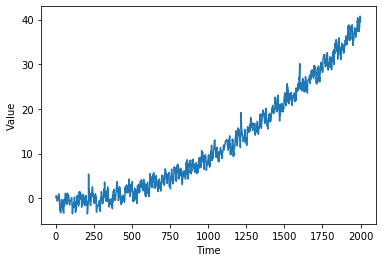

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

#Add outliers

outliers_start = np.mean(signal)+5*np.std(signal)
outliers_end = np.mean(signal)+6*np.std(signal)
outlier_values = np.arange(outliers_start,outliers_end,0.1)
index = np.random.randint(0,len(signal),6)
print(index)
signal_out = signal
for i,ind in enumerate(index):
    signal_out[ind] = outlier_values[i]

# Add a non-linear trend
slope = 1e-5
intercept = -1
nonlinear_trend = slope*time**2 + intercept
signal_trend = signal + nonlinear_trend
#signal_trend = signal_out + nonlinear_trend

#Add white noise
sig_var = np.var(signal)
noise_var = sig_var / 2 #signal is twice the size of noise
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal_trend + white_noise

#Remove data points
del_percent = 0.4
n_del = int(del_percent*np.size(time))
deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
time_unevenly =  np.delete(time, deleted_idx)
signal_unevenly =  np.delete(signal_noise, deleted_idx)


#Plot
plt.plot(time_unevenly,signal_unevenly)
plt.xlabel('Time')
plt.ylabel('Value')

In [72]:
np.where(signal_unevenly==5.20474373)

(array([], dtype=int64),)

In [3]:
print(outlier_values[:5])

[5.00474373 5.10474373 5.20474373 5.30474373 5.40474373]


### Step 2: Create a series object for Pyleoclim

In [7]:
ts = pyleo.Series(time=time_unevenly,value=signal_unevenly)
ts

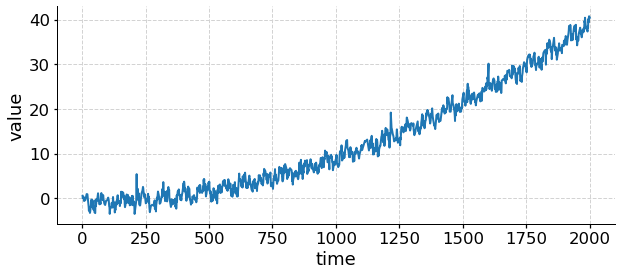

In [8]:
fig,ax = ts.plot()

## Preprocessing

### Standarize

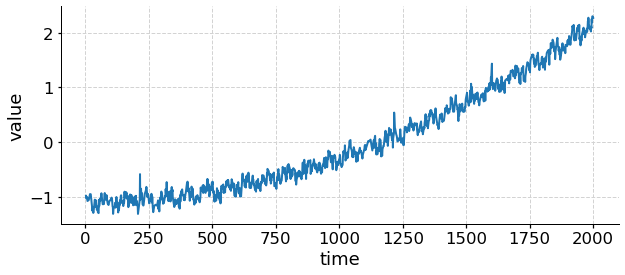

In [9]:
ts_std = ts.standardize()
fig,ax = ts_std.plot()

### Detrend

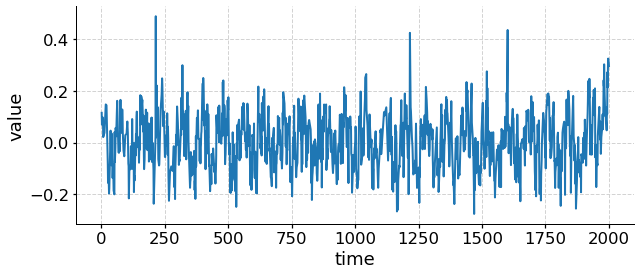

In [10]:
ts_detrended = ts_std.detrend(method='emd')
fig,ax = ts_detrended.plot()

Computing distance from nearest neighbors in order to find knee

In [23]:
nn = NearestNeighbors(4) # 4 nearest neighbors
nbrs =nn.fit(ts_detrended.value.reshape(-1,1))
distances, indices = nbrs.kneighbors(ts_detrended.value.reshape(-1,1))

In [25]:
distances = sorted(distances[:,-1],reverse=True)

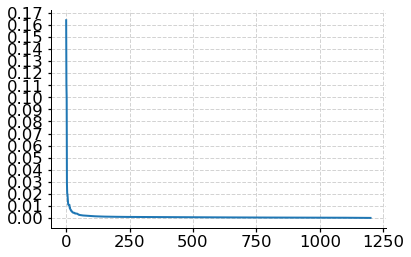

In [36]:
plt.yticks(np.arange(min(distances), max(distances)+1, 0.01))
plt.plot(distances)


We see that knee occurs at 0.01 so eps=0.01

### Detect outliers

Based on the detected outliers, may need to remove them prior to analysis

In [37]:
kwargs={'eps':0.01,'min_samples':4}
is_outlier = ts_detrended.detect_outliers(**kwargs)
np.where(is_outlier==True)

(array([ 118,  632,  699,  701,  728,  864,  891,  937, 1118, 1196, 1199]),)

In [79]:
ts_detrended

Remove Outliers

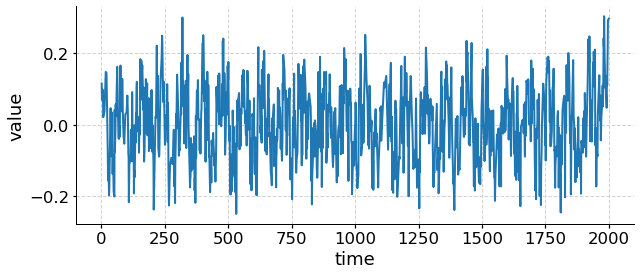

In [38]:
ts_outlier_removed = ts_detrended.remove_outliers(**kwargs)
fig,ax = ts_outlier_removed.plot()